# Koopman operator learning, a toy case: Duffing oscillator

**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x \in \mathbb{R}^n$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x}(t) = f(x(t)) \quad \text(1)
$$

where $\dot{x}(t) := \frac{dx(t)}{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ the equation (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{k+\delta} = x_k + \delta\,f(x_k)$ for a discrete time increment $\delta$, which induces a $O(\delta^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

# arrange the dataset
from sklearn.model_selection import train_test_split

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used. 


In [149]:
def duffing(array_x: np.ndarray) -> np.ndarray:
    array_dx = np.zeros(array_x.shape)
    array_dx[0] = array_x[1]
    array_dx[1] = array_x[0] - array_x[0] ** 3
    return array_dx

In [150]:
t_max = 500  # Time-horizon integration
n_iter = 5000  # Number of time steps integration
n_initial_conditions = 60  # Number of initial conditions

dim_system = 2

# Generate initial conditions
matrix_x0 = (np.random.rand(n_initial_conditions, dim_system) - 0.5) * 4
array_t = np.linspace(0, t_max, n_iter)
array3d_xt = np.zeros((matrix_x0.shape[0], matrix_x0.shape[1], n_iter))

for i in tqdm(range(matrix_x0.shape[0])):
    # Lambda function is used as solve_ivp requires a function of the form f(t, x)
    ode_result = solve_ivp(lambda _t, array_x: duffing(array_x),
                           [0, t_max],
                           matrix_x0[i],
                           method='RK45',
                           t_eval=array_t)

    array3d_xt[i, :] = ode_result.y

100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


The following plot shows trajectories for different initial conditions:

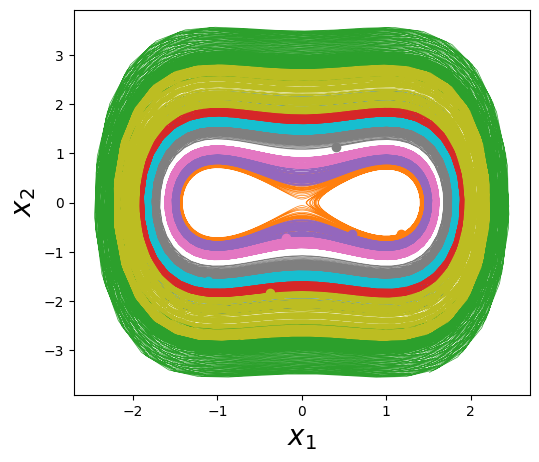

In [4]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(array3d_xt[i, 0, :], array3d_xt[i, 1, :], lw=0.5, color=cm(i))
    ax.plot(array3d_xt[i, 0, 0], array3d_xt[i, 1, 0], 'o', lw=1.5, color=cm(i))  #initial condition
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{k+1} = F(x_k)
$$

where $F$ might be the $\delta$-discretised flow map of the continuous dynamical system in eq (1) given by

$$
x_{k+1} = F(x_k) := x_k + \int_{k}^{k + \delta} f(x(s))ds 
$$

and $X = (x_k)_{k = 0}^N$ the discrete time series of the system state.


The _Koopman_ theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $(g_i)_{i = 1}^m$ given by $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ F(x)
$$

This way, the non-linear dynamics of $x$, described by $F$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

Indeed, let $g_i$ be an observable function and denoting ${g_i}_k := g_i(x_k)$, using the previous equation, the time evolution of the observables is given by

$$
{g_i}_{k+1} = g_i(x_{k+1}) = g_i(F(x_k)) = g_i \circ F(x_k) = \mathcal{K} g_i(x_k) = \mathcal{K} {g_i}_k
$$

then, the linearised dynamics of the observables is given by the following equation

$$
{g_i}_{k+1} = \mathcal{K} {g_i}_k
$$


It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions. 

For this purpose, given a time series $X = \{x_k | k = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png) 

In [151]:

# Flatten the trajectories w.r.t. initial conditions 
# and only keep data in the form of (dim_system, n_iter * n_initial_conditions)
matrix_x_data = array3d_xt[:, :, :-1].swapaxes(0, 1).reshape(2, -1).T
matrix_x_next_data = array3d_xt[:, :, 1:].swapaxes(0, 1).reshape(2, -1).T

(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x_data,
                                             matrix_x_next_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [153]:
torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000  # data per batch

tensor2d_x_data_train = torch.from_numpy(matrix_x_data_train).to(device)
tensor2d_x_next_data_train = torch.from_numpy(matrix_x_next_data_train).to(device)
tensor2d_x_data_test = torch.from_numpy(matrix_x_data_test).to(device)
tensor2d_x_next_data_test = torch.from_numpy(matrix_x_next_data_test).to(device)

torch_dataset_train = TensorDataset(tensor2d_x_data_train,
                                    tensor2d_x_next_data_train)

torch_dataset_test = TensorDataset(tensor2d_x_data_test,
                                   tensor2d_x_next_data_test)

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30  # dimension in Koopman space

In [154]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)


In [155]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x: torch.Tensor):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [156]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim: int, hidden_layer: int, output_dim: int):
        super().__init__()
        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]
        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius) $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem. 

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, using the Perron-Frobenius theorem. Check that the initialization fulfills this property.

In [157]:
class KoopmanOperator(nn.Module):
    def __init__(self, koopman_operator_dim: int):
        super().__init__()
        self.koopman_operator_dim = koopman_operator_dim
        self.K = nn.Linear(koopman_operator_dim, koopman_operator_dim, bias=False)
        self.K.weight.data = 0.9 * torch.eye(koopman_operator_dim) + 0.1 * torch.randn(koopman_operator_dim, koopman_operator_dim)
        max_K, _ = self.frobenius()
        self.K.weight.data = self.K.weight.data / torch.sqrt(max_K + 1e-3)

    def forward(self, tensor2d_x: torch.Tensor):
        # First dimension of tensor2d_x is the batch size
        if tensor2d_x.shape[1] != self.koopman_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.koopman_operator_dim} Input Features')
        ray, _ = self.frobenius()
        if ray > 1:
            self.K.weight.data = self.K.weight.data / torch.sqrt(ray)
        weight = self.K.weight**2
        return torch.matmul(tensor2d_x, weight)
    
    def frobenius(self): 
        sum_K = torch.sum(self.K.weight**2, dim=0)
        max_K = torch.max(sum_K)
        min_K = torch.min(sum_K)
        return max_K, min_K
    
    def check_stability(self, backward=False):
        max_K, min_K = self.frobenius()
        if backward:
            if max_K > 1:
                self.K.weight.data = self.K.weight.data / torch.sqrt(max_K)
        else:
            if max_K > 1:
                print('Koopman Operator is unstable')
            else:
                print('Koopman Operator is stable')
    
    def extract_matrix(self):
        matrix = self.K.weight.detach().cpu().numpy()
        matrix = matrix**2
        return matrix


In [12]:
dim_observable = 10
koopman_operator_test = KoopmanOperator(dim_observable)
koopman_operator_test.check_stability()

Koopman Operator is stable


In [158]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.check_stability()
print(autoencoder)

Koopman Operator is stable
Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [159]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)

optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance; how the scales of different losses are related?
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in autoencoder.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in autoencoder.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
```

In [160]:
class KoopmanLoss(nn.Module):
    """
    Koopman Loss class. Allow to compute the loss of the Koopman model with many different hyperparameters.
    """
    def __init__(self, autoencoder: nn.Module | None = None, koopman_operator: nn.Module | None = None, alpha = torch.tensor([1./3, 1./3, 1./3]), beta = 0., criterion = nn.MSELoss()):
        super().__init__()
        self.autoencoder = autoencoder
        self.koopman_operator = koopman_operator
        self.alpha = alpha # [loss1, loss2, loss3]
        self.beta = beta
        self.criterion = criterion
        self.loss1 = []
        self.loss2 = []
        self.loss3 = []

    def KL_divergence(self, tensor2d_observable_next: torch.Tensor, tensor2d_koopman_observable_next: torch.Tensor):
        """
        Compute a part of the KL divergence
        """
        std_tensor = (tensor2d_koopman_observable_next - tensor2d_observable_next)**2
        std_tensor = torch.mean(std_tensor, dim=0)
        log_std_tensor = torch.log(std_tensor)
        log_std = torch.mean(log_std_tensor)
        std = torch.mean(std_tensor)
        mean_tensor = torch.mean(tensor2d_observable_next, dim=0)
        mean = torch.mean(mean_tensor**2)
        return torch.max(0.5 * (mean + std - log_std - 1), torch.tensor(0.))
    
    def record(self, loss1: torch.Tensor, loss2: torch.Tensor, loss3: torch.Tensor):
        """
        Record the loss of the model
        """
        self.loss1.append(loss1.item())
        self.loss2.append(loss2.item())
        self.loss3.append(loss3.item())

    def __call__(self, tensor2d_x: torch.Tensor,
                tensor2d_x_next: torch.Tensor,
                tensor2d_decoded_x: torch.Tensor,
                tensor2d_observable_next: torch.Tensor,
                tensor2d_koopman_observable_next: torch.Tensor,
                tensor2d_predict_x_next: torch.Tensor,
                record: bool = False):
        # Loss 1 (Reconstruction Loss)
        if self.koopman_operator is not None:
            for param in self.koopman_operator.parameters():
                param.requires_grad = False
        loss1 = self.criterion(tensor2d_x, tensor2d_decoded_x)
        loss1 += self.beta * self.KL_divergence(torch.zeros_like(tensor2d_observable_next), tensor2d_observable_next) # This is litterally like computing the KL divergence but for our deterministic case
        if self.koopman_operator is not None:
            for param in self.koopman_operator.parameters():
                param.requires_grad = True
        # Loss 2 (Koopman Loss)
        if self.autoencoder is not None:
            for param in self.autoencoder.decoder.parameters():
                param.requires_grad = False
        loss2 = self.criterion(tensor2d_observable_next, tensor2d_koopman_observable_next)
        loss2 += self.beta * self.KL_divergence(tensor2d_observable_next, tensor2d_koopman_observable_next)
        if self.autoencoder is not None:
            for param in self.autoencoder.decoder.parameters():
                param.requires_grad = True
        # Loss 3 (Phase Loss)
        loss3 = self.criterion(tensor2d_x_next, tensor2d_predict_x_next)
        # Record the loss
        if record:
            self.record(loss1, loss2, loss3)
        return self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3
    
    def plot(self):
        """
        Plot the loss of the model
        """
        # Final Loss
        final_loss = np.array(self.loss1) * self.alpha[0].item() + np.array(self.loss2) * self.alpha[1].item() + np.array(self.loss3) * self.alpha[2].item()
        # Normalization
        max1 = np.around(np.max(self.loss1), 3)
        max2 = np.around(np.max(self.loss2), 3)
        max3 = np.around(np.max(self.loss3), 3)
        max_final = np.around(np.max(final_loss), 3)
        self.loss1 = np.array(self.loss1) / np.max(self.loss1)
        self.loss2 = np.array(self.loss2) / np.max(self.loss2)
        self.loss3 = np.array(self.loss3) / np.max(self.loss3)
        final_loss = final_loss / np.max(final_loss)
        fig = plt.figure(figsize=(20, 5))
        ax = fig.add_subplot(131)
        ax.plot(self.loss1, label='Reconstruction Loss (Normalized : {})'.format(max1))
        ax.plot(self.loss2, label='Koopman Loss (Normalized : {})'.format(max2))
        ax.plot(self.loss3, label='Phase Loss (Normalized : {})'.format(max3))
        ax.plot(final_loss, label='Final Loss (Normalized : {})'.format(max_final))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()


1.   Reconstruction error
$$
\Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
$$
2.   Prediction error in Koopman space
$$
\Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
$$
3.   Prediction error in the phase space
$$
\Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
$$


**Question 3.**: The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above. How do they evolve in time? Justify your final choice.

0 121.16075146198273
Koopman Operator is unstable
-------------------------------------------------- TEST --------------------------------------------------
0 0.9831801056861877
----------------------------------------------------------------------------------------------------------
1 106.65846568346024
2 77.24154704809189
3 69.26906782388687
4 63.41648414731026
5 55.97262814640999
6 37.26573809981346
7 13.181024864315987
8 9.29098355025053
9 7.627621278166771
10 6.640883889049292
Koopman Operator is stable
-------------------------------------------------- TEST --------------------------------------------------
10 0.05055713281035423
----------------------------------------------------------------------------------------------------------
11 5.948669582605362
12 5.3984186835587025
13 4.925999071449041
14 4.502239964902401
15 4.112528350204229
16 3.74829282797873
17 3.402291839942336
18 3.067620588466525
19 2.7410163823515177
20 2.431266129016876
Koopman Operator is stable
-----------

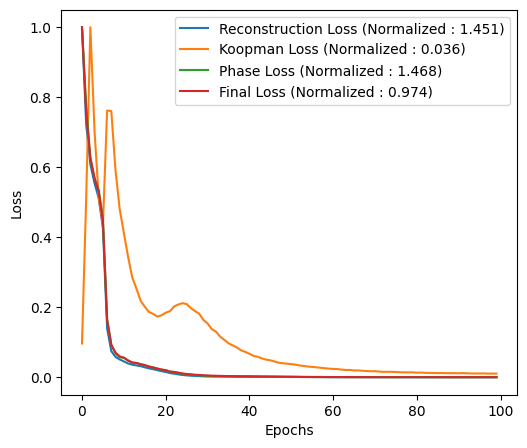

In [156]:
n_batch = len(train_dataloader)
n_epoch = 100  # To be tuned 
basic_loss_koopman = KoopmanLoss(autoencoder, koopman_operator)
KL_loss_koopman = KoopmanLoss(autoencoder, koopman_operator, alpha = torch.tensor([1./3, 1./3, 1./3]), beta = 1.)

loss_koopman = basic_loss_koopman

for epoch in range(n_epoch):
    autoencoder.train()
    koopman_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for i, (tensor2d_batch_x, tensor2d_batch_x_next) in enumerate(train_dataloader):
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_koopman.zero_grad()

        tensor2d_observable = autoencoder.encoder(tensor2d_batch_x)
        tensor2d_observable_next = autoencoder.encoder(tensor2d_batch_x_next)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)

        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)

        tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                       tensor2d_batch_x_next,
                                       tensor2d_decoded_x,
                                       tensor2d_observable_next,
                                       tensor2d_koopman_observable_next,
                                       tensor2d_predict_x_next,
                                       record=(i == n_batch - 1))

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_koopman.step()
        # After the backward pass, we make the Koopman Operator stable again 
        # (This is not necessary because it is done during the forward pass)
        koopman_operator.check_stability(backward=True)

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()

    if epoch % 1 == 0:
        print(epoch, total_train_loss)

    if epoch % 10 == 0:
        autoencoder.eval()
        koopman_operator.eval()
        koopman_operator.check_stability()
        tensor_loss_val = None
        with torch.no_grad():
            total_test_loss = 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                tensor2d_observable = \
                    autoencoder.encoder(tensor2d_batch_x)
                tensor2d_observable_next = \
                    autoencoder.encoder(tensor2d_batch_x_next)
                tensor2d_decoded_x = \
                    autoencoder.decoder(tensor2d_observable)
                tensor2d_koopman_observable_next = \
                    koopman_operator(tensor2d_observable)
                tensor2d_predict_x_next = \
                    autoencoder.decoder(tensor2d_koopman_observable_next)

                tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                               tensor2d_batch_x_next,
                                               tensor2d_decoded_x,
                                               tensor2d_observable_next,
                                               tensor2d_koopman_observable_next,
                                               tensor2d_predict_x_next)

            total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)

koopman_operator.check_stability(backward=True)
loss_koopman.plot()

# Save the model
torch.save(autoencoder.state_dict(), 'basic_autoencoder.pth')
torch.save(koopman_operator.state_dict(), 'basic_koopman_operator.pth')

Koopman Operator is stable
0 261.9467225074768
Koopman Operator is stable
-------------------------------------------------- TEST --------------------------------------------------
0 1.9983108043670654
----------------------------------------------------------------------------------------------------------
1 221.2253042459488
2 175.4140543937683
3 129.13953864574432
4 115.98282790184021
5 109.9602335691452
6 104.50460022687912
7 89.83106189966202
8 62.76849344372749
9 54.2324423789978
10 49.556404650211334
Koopman Operator is stable
-------------------------------------------------- TEST --------------------------------------------------
10 0.39241376519203186
----------------------------------------------------------------------------------------------------------
11 45.008213341236115
12 40.92056351900101
13 37.74743515253067
14 35.4904850423336
15 33.86574003100395
16 32.63392958045006
17 31.619578272104263
18 30.73871937394142
19 29.91507238149643
20 29.142576679587364
Koopman Ope

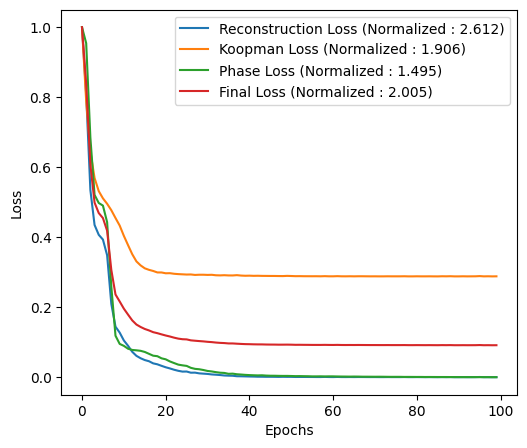

In [168]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.check_stability()
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)

optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_batch = len(train_dataloader)
n_epoch = 100  # To be tuned 
basic_loss_koopman = KoopmanLoss(autoencoder, koopman_operator)
KL_loss_koopman = KoopmanLoss(autoencoder, koopman_operator, alpha = torch.tensor([1./3, 1./3, 1./3]), beta = 1.)

loss_koopman = KL_loss_koopman

for epoch in range(n_epoch):
    autoencoder.train()
    koopman_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for i, (tensor2d_batch_x, tensor2d_batch_x_next) in enumerate(train_dataloader):
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_koopman.zero_grad()

        tensor2d_observable = autoencoder.encoder(tensor2d_batch_x)
        tensor2d_observable_next = autoencoder.encoder(tensor2d_batch_x_next)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)

        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)

        tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                       tensor2d_batch_x_next,
                                       tensor2d_decoded_x,
                                       tensor2d_observable_next,
                                       tensor2d_koopman_observable_next,
                                       tensor2d_predict_x_next,
                                       record=(i == n_batch - 1))

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_koopman.step()
        # After the backward pass, we make the Koopman Operator stable again 
        # (This is not necessary because it is done during the forward pass)
        koopman_operator.check_stability(backward=True)

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()

    if epoch % 1 == 0:
        print(epoch, total_train_loss)

    if epoch % 10 == 0:
        autoencoder.eval()
        koopman_operator.eval()
        koopman_operator.check_stability()
        tensor_loss_val = None
        with torch.no_grad():
            total_test_loss = 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                tensor2d_observable = \
                    autoencoder.encoder(tensor2d_batch_x)
                tensor2d_observable_next = \
                    autoencoder.encoder(tensor2d_batch_x_next)
                tensor2d_decoded_x = \
                    autoencoder.decoder(tensor2d_observable)
                tensor2d_koopman_observable_next = \
                    koopman_operator(tensor2d_observable)
                tensor2d_predict_x_next = \
                    autoencoder.decoder(tensor2d_koopman_observable_next)

                tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                               tensor2d_batch_x_next,
                                               tensor2d_decoded_x,
                                               tensor2d_observable_next,
                                               tensor2d_koopman_observable_next,
                                               tensor2d_predict_x_next)

            total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)

koopman_operator.check_stability(backward=True)
loss_koopman.plot()

# Save the model
torch.save(autoencoder.state_dict(), 'KL_autoencoder.pth')
torch.save(koopman_operator.state_dict(), 'KL_koopman_operator.pth')

> In the class `KoopmanLoss` I implemented, you can find multiple ways to compute the losses used to train the model. A first interesting hyperparameter is `alpha`. It is a tensor which contain the weights that will be used to weight the three losses. In the experiment conducted above we choose to have the same weight for all losses. 
<br><br>
> Then, there is the `beta` parameter. This parameter decide the weight that will be given to the KL-divergence losses that are computed. We choose to add the KL-divergence : One that is in fact only a regularization of the encoder (It is similar to using a gaussian prior) and the second which make the prediction $\mathbf{K_{\phi}} g_{\theta} ( x_k )$ follow a normal law of variance $1$ centered on the expected value (of the next point $g_{\theta} (x_{k+1})$). Both are used here as regularization term thus we weight them in order for them to not impact to much the computation (In the experiment above we did not weight them lower but at $1$ to see the impact those values have).
<br><br>
> We currently cannot conclude much from the computation done above has we are not trying to evaluate both models. But we can still observe that it could be interesting to increase the weight of the "reconstruction" and "phase" losses compared to the Koopman (in hope that it will result in reduced loss). Furthermore, it appears that we should choose a much lower values for `beta`. 

#### Verification

**Question 4.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

/tmp/ipykernel_979/4114783967.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  KL_koopman_operator.load_state_dict(torch.load('KL_koopman_operator.pth'))
/tmp/ipykernel_9

Koopman Operator is stable
Koopman Operator is stable


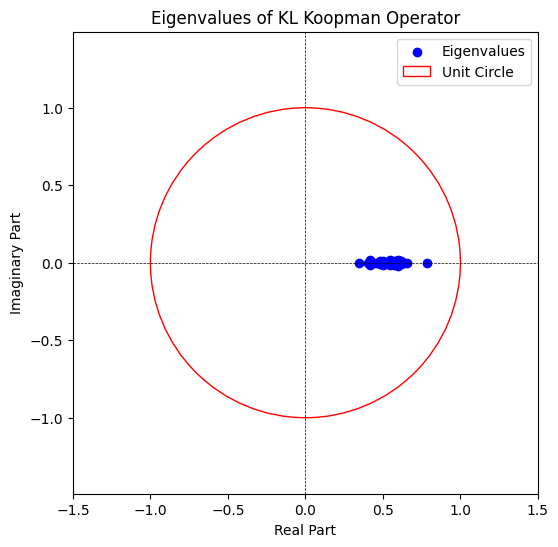

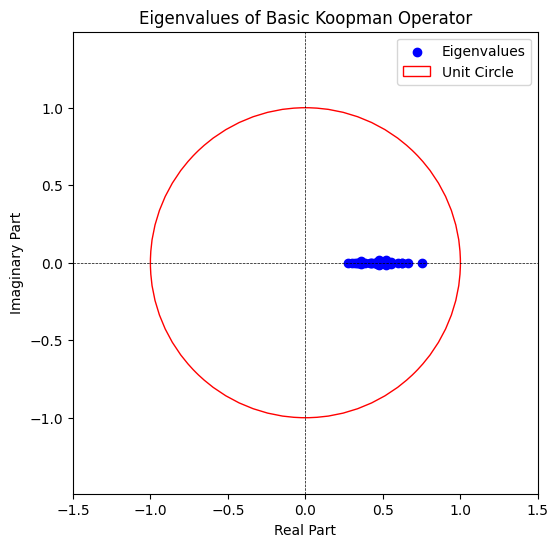

In [19]:
# TODO: Check Koopman stability and plot the eigen values of the Koopman operator against the unit circle
KL_koopman_operator = KoopmanOperator(output_dim).to(device)
KL_koopman_operator.load_state_dict(torch.load('KL_koopman_operator.pth'))
KL_koopman_operator.check_stability()

Base_koopman_operator = KoopmanOperator(output_dim).to(device)
Base_koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
Base_koopman_operator.check_stability()

# Koopman operator matrix
kl_koopman_matrix = KL_koopman_operator.extract_matrix()
base_koopman_matrix = Base_koopman_operator.extract_matrix()

# Compute the eigenvalues of the Koopman operator
eigenvalues_kl, _ = np.linalg.eig(kl_koopman_matrix)
eigenvalues_base, _ = np.linalg.eig(base_koopman_matrix)

# Plot the eigenvalues
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(eigenvalues_kl.real, eigenvalues_kl.imag, color='blue', label='Eigenvalues')
ax.add_artist(plt.Circle((0, 0), 1, color='red', fill=False, label='Unit Circle'))
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Eigenvalues of KL Koopman Operator')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.legend()
plt.show()

# Plot the eigenvalues
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(eigenvalues_base.real, eigenvalues_base.imag, color='blue', label='Eigenvalues')
ax.add_artist(plt.Circle((0, 0), 1, color='red', fill=False, label='Unit Circle'))
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Eigenvalues of Basic Koopman Operator')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.legend()
plt.show()

In [22]:
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('basic_autoencoder.pth'))

/tmp/ipykernel_979/2308665263.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
/tmp/ipykernel_9

<All keys matched successfully>

In [23]:
n_grid = 30
x1_min, x1_max = -2, 2
x2_min, x2_max = -2, 2

array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        array3d_dynamics[i, j, :] = duffing(np.array([x1, x2]))

# Set evaluation mode
autoencoder.eval()
koopman_operator.eval()

array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        # Here we compute a discretised version of the derivative thanks to the Koopman operator
        # and the learned encoder/decoder

        # (x_{k+1} - x_k) / \delta_t = f(x_k) is approximated by (f is duffing here)
        # (Decod(K(Encod(x_k))) - x_k) / \delta_t

        delta_time = (t_max / n_iter)
        array3d_dynamics_pred[i, j, :] = (array_x_next - [x1, x2]) / delta_time


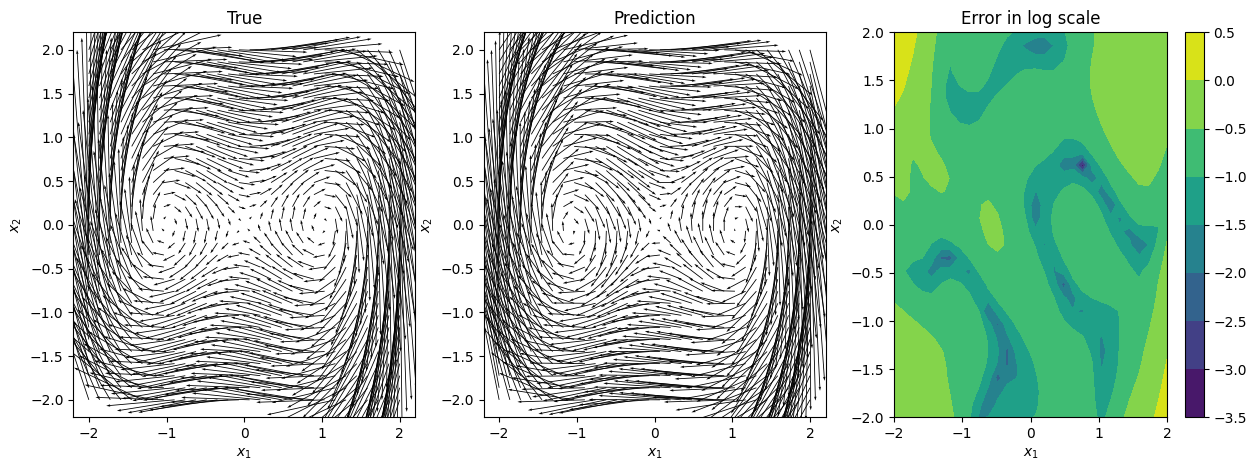

In [24]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics[:, :, 0],
          array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics_pred[:, :, 0],
          array3d_dynamics_pred[:, :, 1], scale=10)

ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Compute the error
matrix_error = np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)
matrix_error_log = np.log10(matrix_error + 1e-10)

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1,
                 matrix_grid_x2,
                 matrix_error_log)

fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

> From this visual inspection it appears that the model learned on only the three losses and no KL-divergence perform very well. But it is arguable that using this visualization we will not be able to select a better model. We need a way to evaluate and order both model performance.
<br><br>
> We will introduce the `koopman_score` based on the visual prediction made above :

In [174]:

def koopman_score(autoencoder: nn.Module, koopman_operator: nn.Module, plot: bool = False, n_grid: int = 30, x1_min: float = -2, x1_max: float = 2, x2_min: float = -2, x2_max: float = 2, array_dynamics: np.ndarray = None, return_score: bool = False):
    array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
    array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
    matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

    if array_dynamics is None:
        array3d_dynamics = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

        for i in range(n_grid):
            for j in range(n_grid):
                x1 = matrix_grid_x1[i, j]
                x2 = matrix_grid_x2[i, j]
                array3d_dynamics[i, j, :] = duffing(np.array([x1, x2]))
    else:
        array3d_dynamics = array_dynamics

    # Set evaluation mode
    autoencoder.eval()
    koopman_operator.eval()

    array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

    for i in range(n_grid):
        for j in range(n_grid):
            x1 = matrix_grid_x1[i, j]
            x2 = matrix_grid_x2[i, j]
            tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
            tensor2d_observable = autoencoder.encoder(tensor2d_x)
            tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)
            tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)
            array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

            # Here we compute a discretised version of the derivative thanks to the Koopman operator
            # and the learned encoder/decoder

            # (x_{k+1} - x_k) / \delta_t = f(x_k) is approximated by (f is duffing here)
            # (Decod(K(Encod(x_k))) - x_k) / \delta_t

            delta_time = (t_max / n_iter)
            array3d_dynamics_pred[i, j, :] = (array_x_next - [x1, x2]) / delta_time

    if plot:
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(131)
        ax.quiver(matrix_grid_x1,
                matrix_grid_x2,
                array3d_dynamics[:, :, 0],
                array3d_dynamics[:, :, 1], scale=10)
        ax.set_title('True')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')

        ax = fig.add_subplot(132)
        ax.quiver(matrix_grid_x1,
                matrix_grid_x2,
                array3d_dynamics_pred[:, :, 0],
                array3d_dynamics_pred[:, :, 1], scale=10)

        ax.set_title('Prediction')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')

    # Compute the error
    matrix_error = np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)
    matrix_error_log = np.log10(matrix_error + 1e-10)
    koopman_scoring = np.mean(matrix_error)

    if plot:
        ax = fig.add_subplot(133)
        cp = ax.contourf(matrix_grid_x1,
                        matrix_grid_x2,
                        matrix_error_log)

        fig.colorbar(cp)
        ax.set_title('Error in log scale')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        plt.show()

    print(f'Koopman Scoring : {koopman_scoring}')

    if return_score:
        return koopman_scoring

In [175]:
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('basic_autoencoder.pth'))

koopman_score(autoencoder, koopman_operator)

/tmp/ipykernel_979/3302908486.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
/tmp/ipykernel_9

Koopman Scoring : 0.2661871314048767


/tmp/ipykernel_979/3274554284.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  koopman_operator.load_state_dict(torch.load('KL_koopman_operator.pth'))
/tmp/ipykernel_979/

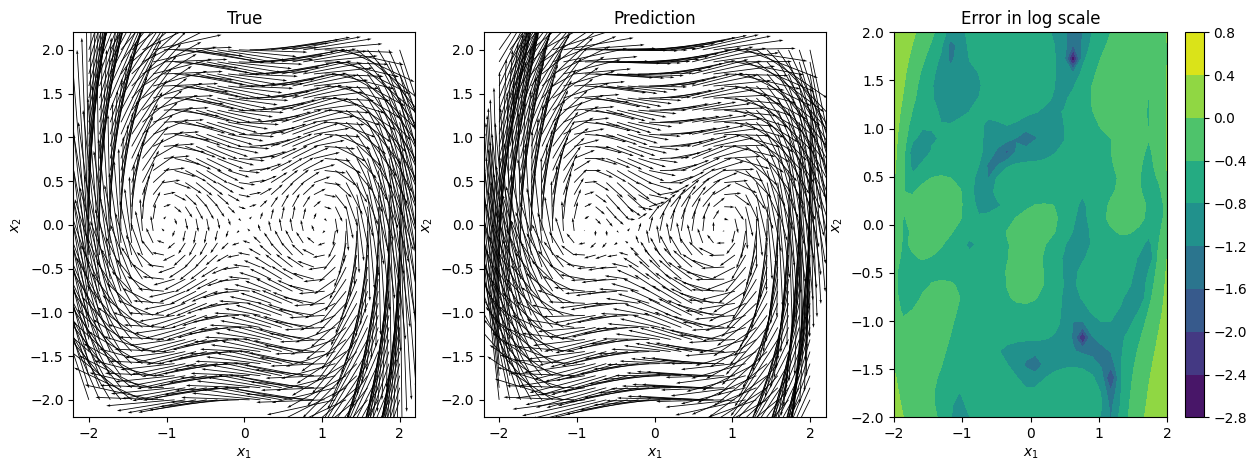

Koopman Scoring : 0.3827589154243469


In [29]:
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('KL_koopman_operator.pth'))
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('KL_autoencoder.pth'))

koopman_score(autoencoder, koopman_operator, plot=True)

> The KL-divergence based loss lead to an underperforming model, but it does not means that it is linked to the nature of the loss. It could also be due to the choice of `beta` which was, as explained before, not obviously the best.
<br><br>
> We will add in the `KoopmanLoss` a dynamical process which will choose the weight value based on the loss (this is done in the `update` function).

In [172]:
class DynamicalKoopmanLoss(KoopmanLoss):
    def __init__(self, autoencoder: nn.Module, koopman_operator: nn.Module, alpha_step: float = 0., beta_step: float = 0., alpha: torch.Tensor = torch.tensor([1./3, 1./3, 1./3]), beta: float = 0., criterion: nn.Module = nn.MSELoss()):
        super().__init__(autoencoder, koopman_operator, alpha, beta, criterion)
        self.alpha_step = alpha_step
        self.beta_step = beta_step
        self.parameters = []
    
    def update(self, epoch: int = None, rate_epoch: int = 10, decrepency: float = None):
        """
        Update the alpha and beta values
        """
        # Get the indices of the losses sorted in ascending order
        sorted_indices = np.argsort([self.loss1[-1], self.loss2[-1], self.loss3[-1]])
        
        # Adjust alpha values 
        self.alpha[sorted_indices[0]] -= self.alpha_step  # Smallest loss
        # Middle loss don't change
        self.alpha[sorted_indices[2]] += self.alpha_step  # Biggest loss
        # normalize alpha
        self.alpha = self.alpha / torch.sum(self.alpha)
        # Adjust beta values
        if epoch is not None:
            if epoch % rate_epoch == 0:
                self.beta -= self.beta_step
                self.beta = max(self.beta, 1e-8)
        if decrepency is not None and epoch is not None:
            if epoch % rate_epoch == 0:
                self.beta_step = decrepency * self.beta
                self.alpha_step = decrepency * self.alpha_step
        self.parameters.append((self.alpha[0].item(), self.alpha[1].item(), self.alpha[2].item(), self.beta))
    
    def plot_parameters(self):
        """
        Plot the evolution of the parameters
        """
        parameters = np.array(self.parameters)
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(121)
        for i in range(3):
            ax.plot(parameters[:, i], label=f'Alpha {i}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Alpha')
        ax.legend()
        ax = fig.add_subplot(122)
        ax.plot(parameters[:, 3], label='Beta')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Beta')
        ax.legend()
        plt.show()


Koopman Operator is stable
0 264.2967801094055
Koopman Operator is stable
-------------------------------------------------- TEST --------------------------------------------------
0 2.073660135269165
----------------------------------------------------------------------------------------------------------
1 239.2807139158249
2 217.50413739681244
3 164.64744973182678
4 119.60489177703857
5 109.18167966604233
6 103.50242561101913
7 93.48899561166763
8 63.10617536306381
9 28.50274856388569
10 21.38118416070938
Koopman Operator is stable
-------------------------------------------------- TEST --------------------------------------------------
10 0.16206267476081848
----------------------------------------------------------------------------------------------------------
11 14.795414201915264
12 13.665653072297573
13 12.827731989324093
14 12.092225566506386
15 11.422003604471684
16 10.800210483372211
17 10.23812960088253
18 9.750074617564678
19 9.333816975355148
20 8.98756755888462
Koopman

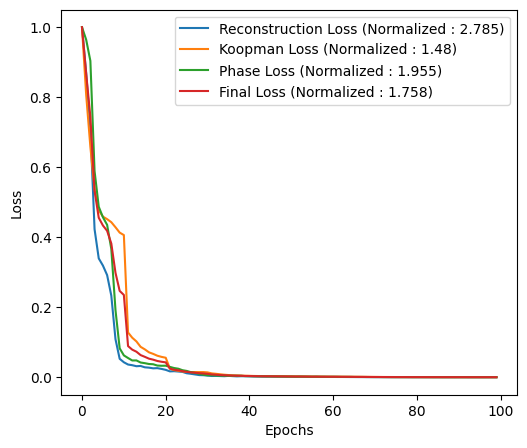

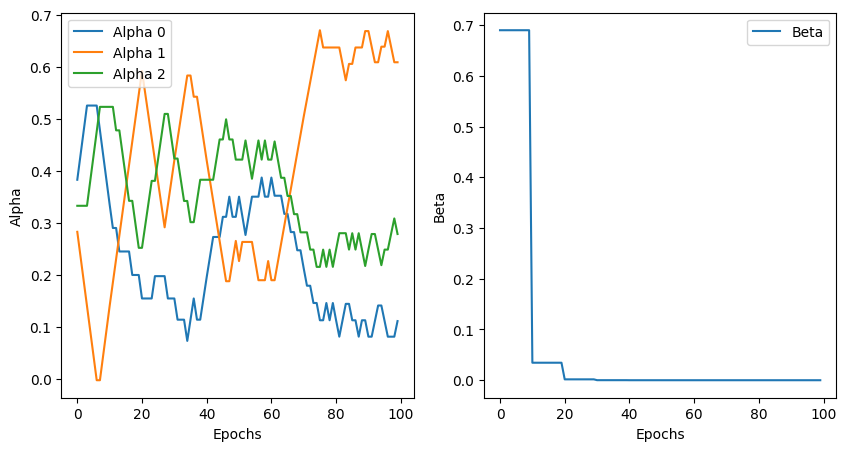

Koopman Scoring : 0.30403879284858704


In [173]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.check_stability()
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)

optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_batch = len(train_dataloader)
n_epoch = 100  # To be tuned 
KL_loss_koopman = DynamicalKoopmanLoss(autoencoder, koopman_operator, alpha_step=0.05, beta_step=0.01, beta=0.7)

loss_koopman = KL_loss_koopman

for epoch in range(n_epoch):
    autoencoder.train()
    koopman_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for i, (tensor2d_batch_x, tensor2d_batch_x_next) in enumerate(train_dataloader):
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_koopman.zero_grad()

        tensor2d_observable = autoencoder.encoder(tensor2d_batch_x)
        tensor2d_observable_next = autoencoder.encoder(tensor2d_batch_x_next)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)

        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)

        tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                       tensor2d_batch_x_next,
                                       tensor2d_decoded_x,
                                       tensor2d_observable_next,
                                       tensor2d_koopman_observable_next,
                                       tensor2d_predict_x_next,
                                       record=(i == n_batch - 1))

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_koopman.step()
        # After the backward pass, we make the Koopman Operator stable again 
        # (This is not necessary because it is done during the forward pass)
        koopman_operator.check_stability(backward=True)

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()

    if epoch % 1 == 0:
        print(epoch, total_train_loss)

    if epoch % 10 == 0:
        autoencoder.eval()
        koopman_operator.eval()
        koopman_operator.check_stability()
        tensor_loss_val = None
        with torch.no_grad():
            total_test_loss = 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                tensor2d_observable = \
                    autoencoder.encoder(tensor2d_batch_x)
                tensor2d_observable_next = \
                    autoencoder.encoder(tensor2d_batch_x_next)
                tensor2d_decoded_x = \
                    autoencoder.decoder(tensor2d_observable)
                tensor2d_koopman_observable_next = \
                    koopman_operator(tensor2d_observable)
                tensor2d_predict_x_next = \
                    autoencoder.decoder(tensor2d_koopman_observable_next)

                tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                               tensor2d_batch_x_next,
                                               tensor2d_decoded_x,
                                               tensor2d_observable_next,
                                               tensor2d_koopman_observable_next,
                                               tensor2d_predict_x_next)

            total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)
    loss_koopman.update(epoch = epoch, rate_epoch = 10, decrepency = 0.95)

koopman_operator.check_stability(backward=True)
loss_koopman.plot()
loss_koopman.plot_parameters()

# Save the model
torch.save(autoencoder.state_dict(), 'final_autoencoder.pth')
torch.save(koopman_operator.state_dict(), 'final_koopman_operator.pth')

koopman_score(autoencoder, koopman_operator)

> Unfortunately, we did not get a better score than the basic loss (without KL divergence) model but we did improve the score (compared to the KL divergence model). It shows that at least, parameters tuning would help improve the model.

### Continuous in time case

Considering $x_k$ as the observation of a state at time $t = k \delta$, and $x_{k+1}$ the state at time $t+ \delta$, for $\delta \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_k)  = \lim_{\delta \rightarrow 0} \frac{\mathcal{K}g(x_k)- g(x_{k})}{\delta} = \frac{g \circ F (x_k) -x_k}{\delta}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

**Important Remark: As long as the system $f$ is known, the three errors can be computed without data belonging to trajectories.**

In [31]:
# Create a dataset for continuous Koopman
# with the same amount of points of the Discontinuous Koopman case
# But here no need to have continuous trajectories
matrix_x0 = (np.random.rand(n_initial_conditions * (n_iter - 1), 2) - 0.5) * 4
matrix_system_derivative_data = np.zeros(matrix_x0.shape)
for i in tqdm(range(matrix_x0.shape[0])):
    matrix_system_derivative_data[i, :] = duffing(matrix_x0[i, :])

100%|██████████| 299940/299940 [00:01<00:00, 297029.34it/s]


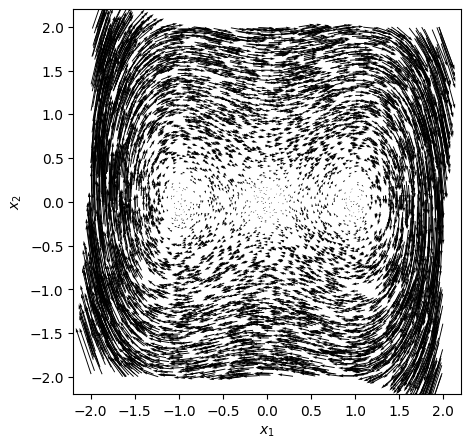

In [32]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.quiver(matrix_x0[::50, 0],
          matrix_x0[::50, 1],
          matrix_system_derivative_data[::50, 0] * 0.2,
          matrix_system_derivative_data[::50, 1] * 0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [33]:
# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30  # dimension in Koopman space
batch_size = 2000  # data per batch

In [34]:
(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x0,
                                             matrix_system_derivative_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

torch_dataset_train = TensorDataset(torch.from_numpy(matrix_x_data_train),
                                    torch.from_numpy(matrix_x_next_data_train))
torch_dataset_test = TensorDataset(torch.from_numpy(matrix_x_data_test),
                                   torch.from_numpy(matrix_x_next_data_test))

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [35]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [36]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [37]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, hidden_layer, output_dim):
        super().__init__()

        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]

        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof (identify the matrix). Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$.

Remark: $- \text{diag}(\vert \Gamma \vert)$ is always a diagonal matrix with non-positive elements.


**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$. Check that the initialization fulfills this property.

In [135]:
class LieModule(nn.Module):
    def __init__(self, lie_operator_dim: int):
        super().__init__()
        self.lie_operator_dim = lie_operator_dim
        self.phi = nn.Linear(lie_operator_dim, lie_operator_dim, bias=False)
        self.gamma = nn.Linear(lie_operator_dim, 1, bias=False)
        self.gamma.weight.data = torch.ones_like(torch.zeros((1, lie_operator_dim)))
        self.phi.weight.data = torch.zeros((lie_operator_dim, lie_operator_dim))
    
    def extract_matrix(self):
        """
        Extract the matrix of the Lie operator
        """
        L = self.phi.weight.data.cpu().numpy()
        L = L - L.T
        gamma = self.gamma.weight.data.cpu().numpy()[0]
        L -= np.diag(np.abs(gamma))
        return L

    def check_stability(self):
        """
        Check the stability of the Lie operator
        """
        # check that real part of the eigenvalues are negative
        eigenvalues = np.linalg.eigvals(self.extract_matrix())
        if np.any(np.real(eigenvalues) >= 0):
            print('The Lie operator is unstable')
        else:
            print('The Lie operator is stable')
        
        
    def forward(self, tensor2d_x: torch.Tensor):
        if tensor2d_x.shape[1] != self.lie_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.koopman_operator_dim} Input Features')

        phi = self.phi.weight
        L = phi - phi.T
        gamma = self.gamma.weight
        gamma = gamma.squeeze()
        L -= torch.diag(torch.abs(gamma))
        return torch.matmul(tensor2d_x, L)

In [141]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
lie_operator = LieModule(output_dim).to(device)
print(autoencoder)
lie_operator.check_stability()

Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)
The Lie operator is stable


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [142]:
learning_rate_autoencoder = 0.0001
learning_rate_lie = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder,
                                         weight_decay=1e-3)
optimiser_lie = torch.optim.Adam(lie_operator.parameters(),
                                 lr=learning_rate_lie,
                                 weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.** Note that here you should use the dynamics $f$ and its values for a set of points belonging to the domain $\left[ -2, 2 \right]^2$ while no data from proper **trajectories** are needed.

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

In [143]:
# Implement the loss function here
class LieLoss(nn.Module):
    """
    Lie Loss class. Allow to compute the loss of the Lie model with many different hyperparameters.
    """
    def __init__(self, autoencoder: nn.Module | None = None, lie_operator: nn.Module | None = None, alpha = torch.tensor([1./3, 1./3, 1./3]), beta = torch.tensor([0., 0.]), criterion = nn.MSELoss()):
        super().__init__()
        self.autoencoder = autoencoder
        self.lie_operator = lie_operator
        self.alpha = alpha # [loss1, loss2, loss3]
        self.beta = beta # [regularization, KL divergence]
        self.criterion = criterion
        self.loss1 = []
        self.loss2 = []
        self.loss3 = []

    def regularization(self, tensor2d_observable: torch.Tensor):
        """
        Compute the regularization term
        """
        mu_tensor = torch.mean(tensor2d_observable, dim=1)
        mu = torch.mean(mu_tensor**2)
        mu_tensor_full = torch.ones_like(tensor2d_observable) * mu_tensor.unsqueeze(1)
        sigma_tensor = torch.mean((tensor2d_observable-mu_tensor_full)**2, dim=1)
        sigma = torch.mean((torch.sqrt(sigma_tensor)-1)**2)
        reg = mu + sigma
        return reg
    
    def KL_divergence(self, tensor2d_observable_next: torch.Tensor, tensor2d_lie_observable_next: torch.Tensor):
        """
        Compute a part of the KL divergence
        """
        std_tensor = (tensor2d_lie_observable_next - tensor2d_observable_next)**2
        std_tensor = torch.mean(std_tensor, dim=0)
        log_std_tensor = torch.log(std_tensor)
        log_std = torch.mean(log_std_tensor)
        std = torch.mean(std_tensor)
        mean_tensor = torch.mean(tensor2d_observable_next, dim=0)
        mean = torch.mean(mean_tensor**2)
        return torch.max(0.5 * (mean + std - log_std - 1), torch.tensor(0.))
    
    def record(self, loss1: torch.Tensor, loss2: torch.Tensor, loss3: torch.Tensor):
        """
        Record the loss of the model
        """
        self.loss1.append(loss1.item())
        self.loss2.append(loss2.item())
        self.loss3.append(loss3.item())

    def __call__(self, tensor2d_x: torch.Tensor,
                tensor2d_x_next: torch.Tensor,
                tensor2d_decoded_x: torch.Tensor,
                tensor2d_observable: torch.Tensor,
                tensor2d_lie_observable_next: torch.Tensor,
                tensor2d_predict_x_next: torch.Tensor,
                tensor2d_jvp: torch.Tensor,
                record: bool = False):
        # Loss 1 (Reconstruction Loss)
        if self.lie_operator is not None:
            for param in self.lie_operator.parameters():
                param.requires_grad = False
        loss1 = self.criterion(tensor2d_x, tensor2d_decoded_x)
        loss1 += self.beta[0] * self.regularization(tensor2d_observable)
        if self.lie_operator is not None:
            for param in self.lie_operator.parameters():
                param.requires_grad = True
        # Loss 2 (Koopman Loss)
        if self.autoencoder is not None:
            for param in self.autoencoder.decoder.parameters():
                param.requires_grad = False
        loss2 = self.criterion(tensor2d_jvp, tensor2d_lie_observable_next)
        loss2 += self.beta[1] * self.KL_divergence(tensor2d_jvp, tensor2d_lie_observable_next)
        if self.autoencoder is not None:
            for param in self.autoencoder.decoder.parameters():
                param.requires_grad = True
        # Loss 3 (Phase Loss)
        loss3 = self.criterion(tensor2d_x_next, tensor2d_predict_x_next)
        # Record the loss
        if record:
            self.record(loss1, loss2, loss3)
        return self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3
    
    def plot(self):
        """
        Plot the loss of the model
        """
        # Final Loss
        final_loss = np.array(self.loss1) * self.alpha[0].item() + np.array(self.loss2) * self.alpha[1].item() + np.array(self.loss3) * self.alpha[2].item()
        # Normalization
        max1 = np.around(np.max(self.loss1), 3)
        max2 = np.around(np.max(self.loss2), 3)
        max3 = np.around(np.max(self.loss3), 3)
        max_final = np.around(np.max(final_loss), 3)
        self.loss1 = np.array(self.loss1) / np.max(self.loss1)
        self.loss2 = np.array(self.loss2) / np.max(self.loss2)
        self.loss3 = np.array(self.loss3) / np.max(self.loss3)
        final_loss = final_loss / np.max(final_loss)
        fig = plt.figure(figsize=(20, 5))
        ax = fig.add_subplot(131)
        ax.plot(self.loss1, label='Reconstruction Loss (Normalized : {})'.format(max1))
        ax.plot(self.loss2, label='Lie Loss (Normalized : {})'.format(max2))
        ax.plot(self.loss3, label='Phase Loss (Normalized : {})'.format(max3))
        ax.plot(final_loss, label='Final Loss (Normalized : {})'.format(max_final))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()

**Since trajectories are not needed**, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$.

0 178.62219643592834
The Lie operator is stable
-------------------------------------------------- TEST --------------------------------------------------
0 44.30178999900818
----------------------------------------------------------------------------------------------------------
1 174.67459428310394
2 162.5375999212265
3 149.59128558635712
4 127.54626673460007
5 97.99451440572739
6 84.92790925502777
7 76.3412474989891
8 68.06817662715912
9 60.34045299887657
10 54.584384590387344
The Lie operator is stable
-------------------------------------------------- TEST --------------------------------------------------
10 13.104698479175568
----------------------------------------------------------------------------------------------------------
11 50.15670967102051
12 45.890368938446045
13 41.23931020498276
14 36.16041108965874
15 31.363619551062584
16 27.4429918974638
17 24.353317618370056
18 21.93179926276207
19 20.113117143511772
20 18.78892982006073
The Lie operator is stable
-----------

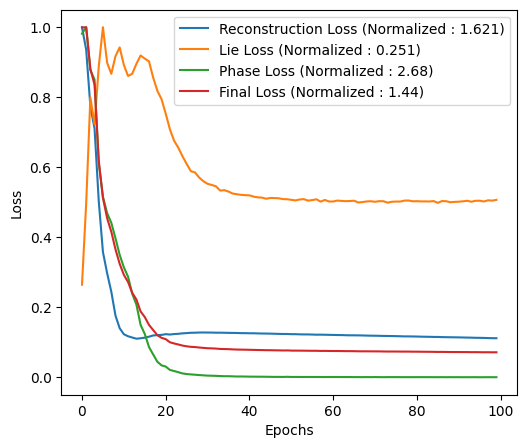

In [144]:
loss = LieLoss(autoencoder, lie_operator, alpha=torch.tensor([1./3, 1./3, 1./3]), beta=torch.tensor([0.5, 0.]))

n_batch = len(train_dataloader)
n_epoch = 100  # To be tuned 

for epoch in range(n_epoch):
    autoencoder.train()
    lie_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for i, (tensor2d_batch_x, tensor2d_batch_x_next) in enumerate(train_dataloader):
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_lie.zero_grad()

        # dgX = lie_operator * gX
        # jvp = \nabla_x g (x) * f(x) (jvp: jacobian vector product)
        (tensor2d_observable, tensor2d_jvp) = \
            autograd.functional.jvp(autoencoder.encoder,
                                    tensor2d_batch_x,
                                    tensor2d_batch_x_next,
                                    create_graph=True)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

        tensor_loss_val = \
            loss(tensor2d_x=tensor2d_batch_x,
                 tensor2d_x_next=tensor2d_batch_x_next,
                 tensor2d_decoded_x=tensor2d_decoded_x,
                 tensor2d_observable=tensor2d_observable,
                 tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                 tensor2d_predict_x_next=tensor2d_predict_x_next,
                 tensor2d_jvp=tensor2d_jvp,
                 record=(i == n_batch - 1))

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_lie.step()

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()
    if epoch % 1 == 0:
        print(epoch, total_train_loss)

    if epoch % 10 == 0:
        lie_operator.check_stability()
        autoencoder.eval()
        lie_operator.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                (tensor2d_observable, tensor2d_jvp) = \
                    autograd.functional.jvp(autoencoder.encoder,
                                            tensor2d_batch_x,
                                            tensor2d_batch_x_next,
                                            create_graph=True)
                tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

                tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
                tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

                tensor_loss_val = \
                    loss(tensor2d_x=tensor2d_batch_x,
                         tensor2d_x_next=tensor2d_batch_x_next,
                         tensor2d_decoded_x=tensor2d_decoded_x,
                         tensor2d_observable=tensor2d_observable,
                         tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                         tensor2d_predict_x_next=tensor2d_predict_x_next,
                         tensor2d_jvp=tensor2d_jvp)

                total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)

loss.plot()

# Save the model
torch.save(autoencoder.state_dict(), 'lie_autoencoder.pth')
torch.save(lie_operator.state_dict(), 'lie_operator.pth')



### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

/tmp/ipykernel_979/1303580856.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Base_lie_operator.load_state_dict(torch.load('lie_operator.pth'))


The Lie operator is stable


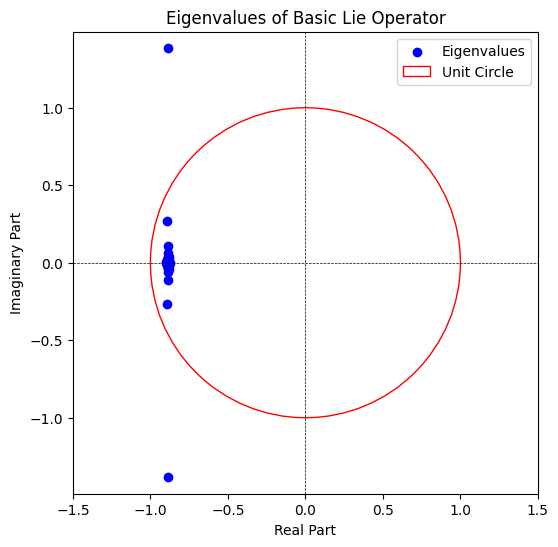

In [145]:
Base_lie_operator = LieModule(output_dim).to(device)
Base_lie_operator.load_state_dict(torch.load('lie_operator.pth'))

# TODO: Check the eigenvalues real part
Base_lie_operator.check_stability() # If all eigenvalues real part are negative, the Lie operator is stable

# Koopman operator matrix
base_lie_matrix = Base_lie_operator.extract_matrix()

# Compute the eigenvalues of the Koopman operator
eigenvalues_base, _ = np.linalg.eig(base_lie_matrix)

# TODO: Plot the eigenvalues
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(eigenvalues_base.real, eigenvalues_base.imag, color='blue', label='Eigenvalues')
ax.add_artist(plt.Circle((0, 0), 1, color='red', fill=False, label='Unit Circle'))
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Eigenvalues of Basic Lie Operator')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.legend()
plt.show()

In [180]:
# load model
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('lie_autoencoder.pth'))
lie_operator = LieModule(output_dim).to(device)
lie_operator.load_state_dict(torch.load('lie_operator.pth'))

n_grid = 30
array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2))

for i in range(n_grid):
    for j in range(n_grid):
        array3d_dynamics[i, j, :] = duffing(np.array([matrix_grid_x1[i, j], matrix_grid_x2[i, j]]))

autoencoder.eval()
lie_operator.eval()
array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        array3d_dynamics_pred[i, j, :] = array_x_next


/tmp/ipykernel_979/2627022570.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('lie_autoencoder.pth'))
/tmp/ipykernel_979/262702257

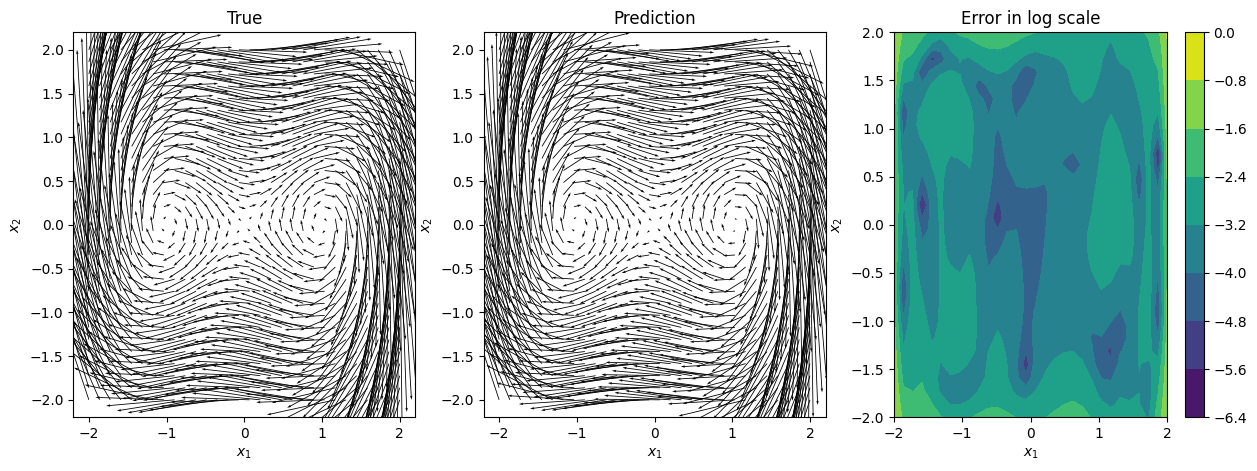

Lie Scoring : 0.05856269631502881


In [181]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics[:, :, 0], array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics_pred[:, :, 0], array3d_dynamics_pred[:, :, 1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1, matrix_grid_x2,
                 np.log(np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

matrix_error = np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)
lie_score = np.mean(matrix_error)
print(f'Lie Scoring : {lie_score}')


**Question 7.** : Compare and comment below the two approaches (discrete vs continuous operator).

In [188]:
# load all models
# Basic Koopman
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('basic_autoencoder.pth'))
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('basic_koopman_operator.pth'))
basic_score = koopman_score(autoencoder, koopman_operator, plot=False, return_score=True)

# KL Koopman
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('KL_autoencoder.pth'))
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('KL_koopman_operator.pth'))
kl_score = koopman_score(autoencoder, koopman_operator, plot=False, return_score=True)

# Dynamic Koopman (Final model)
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
autoencoder.load_state_dict(torch.load('final_autoencoder.pth'))
koopman_operator = KoopmanOperator(output_dim).to(device)
koopman_operator.load_state_dict(torch.load('final_koopman_operator.pth'))
final_score = koopman_score(autoencoder, koopman_operator, plot=False, return_score=True)

# Lie model
print(f'Lie Scoring : {lie_score}')

# choose best model :
scores = np.array([basic_score, kl_score, final_score, lie_score])
best_model = np.argmin(scores)
print(f'\n\n  Best model is {["Basic Koopman", "KL Koopman", "Dynamic Koopman", "Lie Model"][best_model]} with a score of {scores[best_model]}')


/tmp/ipykernel_979/1542999776.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('basic_autoencoder.pth'))
/tmp/ipykernel_979/1542999

Koopman Scoring : 0.2661871314048767


/tmp/ipykernel_979/1542999776.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('KL_autoencoder.pth'))
/tmp/ipykernel_979/154299977

Koopman Scoring : 0.3827589154243469


/tmp/ipykernel_979/1542999776.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('final_autoencoder.pth'))
/tmp/ipykernel_979/154299

Koopman Scoring : 0.30403879284858704
Lie Scoring : 0.05856269631502881


  Best model is Lie Model with a score of 0.05856269631502881


> If we use the scoring to deduce which model is the best it appears that it is by far the continuous approach with the Lie model that is the best. But the score is not enough to determine completely which model is better. Indeed, the scoring task is not exactly the same in both cases, thus we need to take a look at the visualization.
<br><br>
> First, when we compare the basic Koopman model with others Koopman we have trained, we can observe that the basic Koopman (which perform the best of the Koopman model based on score) has a better prediction on the boundary than the others. Then, if we take a look at the prediction made by the continuous model, we observe the same thing : the Lie model outperform all Koopman models on the boundary. This is the main point that will allow us to understand why is the Lie model better.
<br><br>
> If we dive a bit more into what we are trying to compute and do an analogy with Markov chain, then we can say that with our operators (Koopman and Lie) we are trying to compute the transition matrix of our Markov chain (at least of the embedded values in the encoder space). Then, when we do the Koopman method, we assume that our process is time-dependant (time refer here to the chain indices $k$) and we try to predict the next step from some given state while allowing us to take into account the time. This results in the observation we made : A "border effect". Indeed, the nearest we are from the boundary the more advanced we are (in time term). This can results in unstable prediction at the end of a trajectory. However, when we train the Lie model, we are less time-dependant (it is not perfect obviously) and we are ultimately trying to compute a stationnary kernel for our Markov chain, thus we have less of this border effect.
<br><br>
> The intuition is that thanks to the fact that we have the dynamical function $f$, we can easily predict the next step without time dependance. But this is a strong assumption. In many physics phenomena we do not have an easy to compute dynamical function (fluid mecanic for example). There exist method to reduce the dynamical function so that it can be used but then we introduce an error which propagate and also result in a border effect. Therefore, the question of using empirical data (thus the Koopman method) is not meaningless.
<br><br>
<br><br>
> To summarize : If we have access to an **easy to compute** dynamical function, the Lie method will almost always be the best. But *if we need to approximate the dynamical function* **or** *the dynamical function is computationally expensive* **or** *we have a lot of experimental data*, then there will be a trade-off between the error induced by the Koopman method and the error induced by the reduced dynamical function for the Lie method which call for further test to be made on both method applied to the specific task we want to solve.

**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**